In [ ]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import DiffuScope

In [ ]:
import random
#random_seed = random.randint(0, 10000)
random_seed = 2023
DiffuScope.fix_seed(random_seed)

In [65]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
adata = sc.read_visium("/work/data1/cyx/spatialLIBD/151672/",
                       count_file='151672_filtered_feature_bc_matrix.h5',
                       source_image_path='/work/data1/cyx/spatialLIBD/151672/spatial/tissue_lowres_image.png')
adata.var_names_make_unique()

In [66]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

In [ ]:
graph_dict = DiffuScope.graph_construction(adata, 12)
print(graph_dict)

{'adj_norm': tensor(indices=tensor([[   0,  428,  526,  ..., 3759, 3931, 4014],
                       [   0,    0,    0,  ..., 4014, 4014, 4014]]),
       values=tensor([0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769]),
       size=(4015, 4015), nnz=53447, layout=torch.sparse_coo), 'adj_label': tensor(indices=tensor([[   0,    0,    0,  ..., 4014, 4014, 4014],
                       [   0,  428,  526,  ..., 3759, 3931, 4014]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(4015, 4015), nnz=53447, dtype=torch.float64,
       layout=torch.sparse_coo), 'norm_value': 0.5016632768561313}


In [ ]:
sedr_net = DiffuScope.DiffScope(adata.obsm['X_pca'], graph_dict, mode='clustering', device=device)
using_dec = True
if using_dec:
    sedr_net.train_with_dec(N=1)
else:
    sedr_net.train_without_dec(N=1)
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['DiffuScope'] = sedr_feat

100%|█████████████████████████████████████████| 200/200 [03:00<00:00,  1.11it/s]


In [ ]:
import numpy as np
def mclust_R(adata, n_clusters, use_rep='DiffuScope', key_added='DiffuScope', random_seed=2023):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    # import os
    # os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'
    modelNames = 'EEE'

    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[use_rep]), n_clusters, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs[key_added] = mclust_res
    adata.obs[key_added] = adata.obs[key_added].astype('int')
    adata.obs[key_added] = adata.obs[key_added].astype('category')

    return adata

In [ ]:
n_clusters = 5
mclust_R(adata, n_clusters, use_rep='DiffuScope', key_added='DiffuScope')

fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 4015 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'SEDR'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg'
    obsm: 'spatial', 'X_pca', 'SEDR'
    layers: 'count'

In [71]:
true = pd.read_csv('/work/data1/cyx/spatialLIBD/151672/cluster_labels_151672.csv', index_col=0)

In [ ]:
common_index = true.index.intersection(adata.obs['DiffuScope'].index)
common_index

Index(['AAACAAGTATCTCCCA-1', 'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1',
       'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1',
       'AAACCACTACACAGAT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1',
       'AAACCGGGTAGGTACC-1',
       ...
       'TTGTGGTGGTACTAAG-1', 'TTGTGTATGCCACCAA-1', 'TTGTGTTTCCCGAAAG-1',
       'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1', 'TTGTTGTGTGTCAAGA-1',
       'TTGTTTCACATCCAGG-1', 'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=3888)

In [ ]:
adata.obs['DiffuScope'].to_csv('DiffuScope_151671.csv', index=True) 

In [ ]:
true_common = true.loc[common_index]
pre_common = adata.obs['DiffuScope'].loc[common_index]

In [75]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, fowlkes_mallows_score, completeness_score, homogeneity_score, accuracy_score
# 如果是DataFrame中的一列数据，使用.squeeze()方法将其转为1D
labels_true = true_common.squeeze()
labels_pred = pre_common.squeeze()

# 计算ARI
ari = adjusted_rand_score(labels_true, labels_pred)

# 计算NMI
nmi = normalized_mutual_info_score(labels_true, labels_pred)

# 计算AMI
ami = adjusted_mutual_info_score(labels_true, labels_pred)

# 计算FMI
fmi = fowlkes_mallows_score(labels_true, labels_pred)

# 计算COMP (Completeness)
comp = completeness_score(labels_true, labels_pred)

# 计算HOMO (Homogeneity)
homo = homogeneity_score(labels_true, labels_pred)

# 计算ACC (Accuracy)
acc = accuracy_score(labels_true, labels_pred)

# 输出结果
print(f"ARI: {ari}")
print(f"NMI: {nmi}")
print(f"AMI: {ami}")
print(f"FMI: {fmi}")
print(f"COMP: {comp}")
print(f"HOMO: {homo}")
print(f"ACC: {acc}")

ARI: 0.6230738072723876
NMI: 0.6928245708289755
AMI: 0.6923929850229594
FMI: 0.7205432702895531
COMP: 0.682847378578621
HOMO: 0.703097642930223
ACC: 0.31635802469135804


[<Axes: title={'center': 'SEDR'}, xlabel='spatial1', ylabel='spatial2'>]

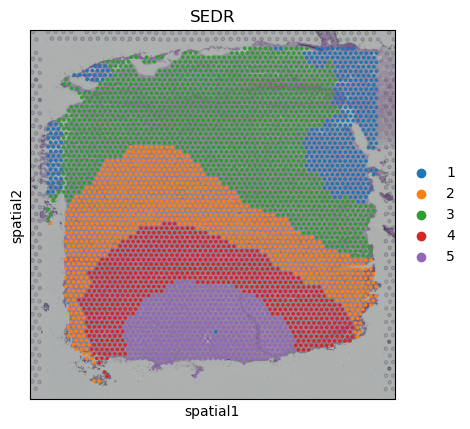

In [ ]:
sc.pl.spatial(adata, color='DiffuScope', show=False)

In [ ]:
sc.pl.spatial(adata, color='DiffuScope', show=False, save = "151672.pdf")

[<Axes: title={'center': 'SEDR'}, xlabel='spatial1', ylabel='spatial2'>]